The aim of this notebook is to create a "quantum calculator" circuit. Specifically, given an input positive integer $d$, output a quantum circuit QCALC (dependent on $d$) on $3d+1$ qubits (and possible further ancillas). The circuit QCALC should satisfy, for standard $d$-qubit basis vectors $|x\rangle$ and $|y\rangle$:
$$ |x\rangle_{d} |y\rangle_{d} |0\rangle_{1} |0\rangle_{d} \mapsto |x\rangle_{d} |y\rangle_{d} |0\rangle_{1} |x+y\rangle_{d} $$
and
$$ |x\rangle_{d} |y\rangle_{d} |1\rangle_{1} |0\rangle_{d} \mapsto |x\rangle_{d} |y\rangle_{d} |1\rangle_{1} |x\cdot y\rangle_{d} $$
where we identify $x$ (resp. $y$) with $\sum_{j=0}^{d-1}x_{j}2^{j}$ (resp. $\sum_{j=0}^{d-1}y_{j}2^{j}$) inside $\mathbb{Z}/2^{d}\mathbb{Z}$, and so the addition and multiplication are modulo $2^{d}$. 

In [11]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Operator

import matplotlib.pyplot as plt

import numpy as np

import pylatexenc

First, we give a "naive" version, without making use of the Quantum Fourier Transform (QFT).

In [29]:
def QCALC(d):
    # integer d for the length of input qubits
    
    # setting up the variables
    
    # first input number
    x = QuantumRegister(size=d, name="x") 
    
    # second input number
    y = QuantumRegister(size=d, name="y") 
    
    # operation determined by z; 0 for addition, 1 for multiplication
    z = QuantumRegister(size=1, name="z") 
    
    # "output" number; the circuit will send the zero state to the result (either x+y or x*y)
    w = QuantumRegister(size=d, name="w") 
    
    # ancillas used for calculation - just used for multi-controlled NOT gates, could be removed 
    a = AncillaRegister(size=1, name="a")
    b = AncillaRegister(size=1, name="b")
     
    # Initiate the set-up of the circuit    
    quantum_calc = QuantumCircuit(x, y, z, w, a, b, name="QCALC")
    
    # Addition if z=0; switch the parity of z, then use z to control all these gates.
    quantum_calc.x(z)
    
    # deal with entries 1 through d-1 first
    for i in range(d-1):
        # start at the "largest" contributor in position d-1, and work backwards
        
        # add the x-component to w
        quantum_calc.ccx(z,x[d-i-1],w[d-i-1])
        
        # add the y-component to w
        quantum_calc.ccx(z,y[d-i-1],w[d-i-1])
        
        # carry one from position lower if necessary
        # use a as "carry indicator"
        quantum_calc.ccx(x[d-i-2],y[d-i-2],a)
        quantum_calc.ccx(z,a,w[d-i-1])
        
        # reset a
        quantum_calc.ccx(x[d-i-2],y[d-i-2],a)
    
    # finish with 0th entry, no need to carry   
    quantum_calc.ccx(z,x[0],w[0])
    quantum_calc.ccx(z,y[0],w[0])
    
    # flip z-qubit back to original state
    quantum_calc.x(z)
    
    # now, for multiplication if z=1
    # in essence, doing \sum_{j} 2^{j}y[j]*x.
    for j in range(d):
        for i in range(d-j-1):
            # add the term arising from the j-th y-component and the (d-i-j-1)-th x-component to the (d-i-1)th component of w
            # here a acts as an indicator for a term coming from y[j] and x[d-i-j-1]
            quantum_calc.ccx(y[j],x[d-i-j-1],a)
            quantum_calc.ccx(z,a,w[d-i-1])
            
            #reset a
            quantum_calc.ccx(y[j],x[d-i-j-1],a)
            
            # carry one from the lower w-component if necessary
            quantum_calc.ccx(y[j],x[d-i-j-2],a)
            quantum_calc.ccx(z,w[d-i-2],b)
            quantum_calc.ccx(a,b,w[d-i-1])
            
            # reset ancillas
            quantum_calc.ccx(y[j],x[d-i-j-2],a)
            quantum_calc.ccx(z,w[d-i-2],b)
            
        # again, deal with x[0] separately
        quantum_calc.ccx(y[j],x[0],a)
        quantum_calc.ccx(z,a,w[j])
        quantum_calc.ccx(y[j],x[0],a)
    
    
    return quantum_calc
    

In this implementation, we use two ancillas. We can see that the number of gates grows as $O(d^{2})$ ($O(d)$ for addition, $O(d^{2})$ for multiplication).

Below are the circuit diagrams for $d=1$ and $d=2$ respectively:

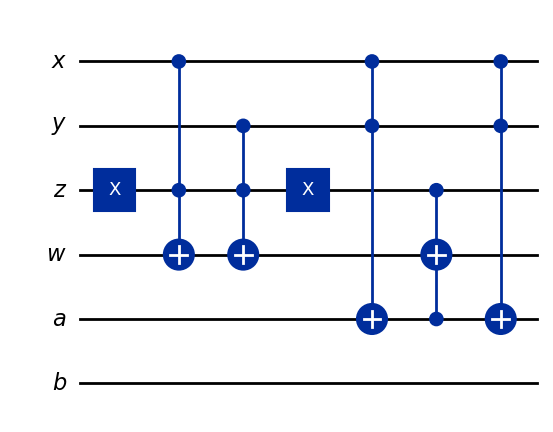

In [30]:
QCALC(1).draw(output="mpl")

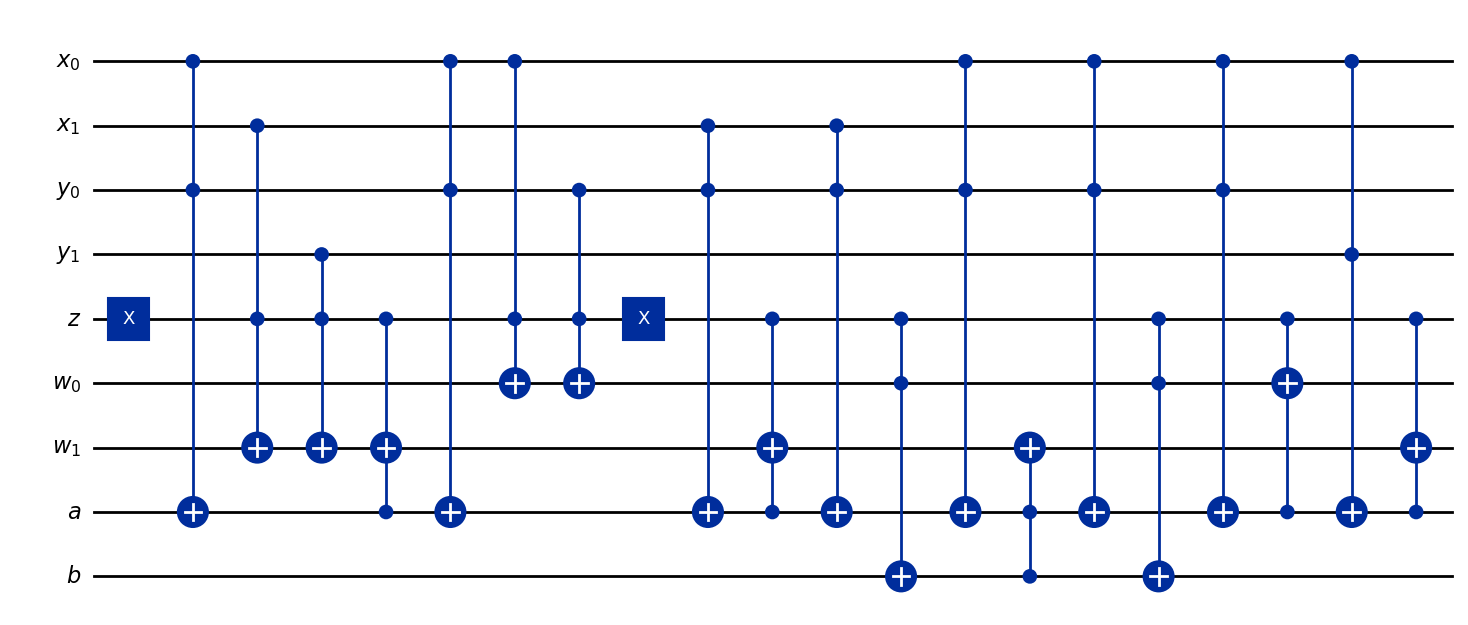

In [14]:
QCALC(2).draw(output="mpl")

**Example 1** Below is a very simple example, showing 1+0 = 1. We use the matrix for the circuit applied to an elementary column vector containing a single 1 (and the rest zero) to compute.

In [36]:
QCALC_matrix = Operator(QCALC(1))

In [31]:
start_vector_one_a = np.zeros(2**6)
start_vector_one_a[1] = 1 # position 1 corresponds to the basis vector with x in state 1 and the other qubits in state 0
start_vector_one_a.reshape(-1,1)

end_vector_one_a = np.matmul(QCALC_matrix, start_vector_one_a)
print(end_vector_one_a)

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


We see a vector of zeroes except a single value 1 at index 9, corresponding to $x$ and $w$ in state $1$ and the remaining qubits in state 0.

Another simple example, this time showing $1\times 1 =1$:

In [32]:
start_vector_one_b = np.zeros(2**6)
start_vector_one_b[7] = 1 # position 7 corresponds to the basis vector with x, y and z in state 1 and the other qubits in state 0
start_vector_one_b.reshape(-1,1)

end_vector_one_b = np.matmul(QCALC_matrix, start_vector_one_b)
print(end_vector_one_b)

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


We see a single entry 1 at index 15, corresponding to $x$, $y$, $z$ and now $w$ all in state $1$.

Next, we implement a version using the QFT, based on Draper's construction [here](https://arxiv.org/pdf/quant-ph/0008033). First, we create circuits implementing the QFT itself (and its inverse).

In [15]:
def QFT(d):
    x = QuantumRegister(size=d, name="x")
    QFT_circuit = QuantumCircuit(x, name="QFT")

    # Swap qubits into the order we will need
    for i in range(int((d-1)/2)):
        QFT_circuit.cx(x[i],x[d-1-i])
        QFT_circuit.cx(x[d-1-i],x[i])
        QFT_circuit.cx(x[i],x[d-1-i])
    
    # Apply appropriate phase shifts
    for i in range(d):
    
        QFT_circuit.h(i)
        for j in range(i+1,d):
            #angle of rotation
            theta = np.pi / (2**(j-i))
            # decompose cp(theta,j,i) into cx and p gates      
            QFT_circuit.cx(j,i)
            QFT_circuit.p(-theta/2,i)
            QFT_circuit.cx(j,i)
            QFT_circuit.p(theta/2,i)
            QFT_circuit.p(theta/2,j)
    return QFT_circuit
        
def QFT_inverse(d):
    x = QuantumRegister(size=d, name="x")
    QFT_inv_circuit = QuantumCircuit(x, name="QFT inverse")
    
    for i in range(d-1,-1,-1):   
        
        for j in range(d-1,i,-1):
            #angle of rotation
            theta = np.pi / (2**(j-i))
            QFT_inv_circuit.p(-theta/2,j)
            QFT_inv_circuit.p(-theta/2,i)
            QFT_inv_circuit.cx(j,i)
            QFT_inv_circuit.p(theta/2,i)
            QFT_inv_circuit.cx(j,i)     
            
        
        QFT_inv_circuit.h(i)
    
    
    for i in range(int((d-1)/2)):
        QFT_inv_circuit.cx(x[i],x[d-1-i])
        QFT_inv_circuit.cx(x[d-1-i],x[i])
        QFT_inv_circuit.cx(x[i],x[d-1-i])
        
    return QFT_inv_circuit

An example of the circuits for QFT and QFT inverse:

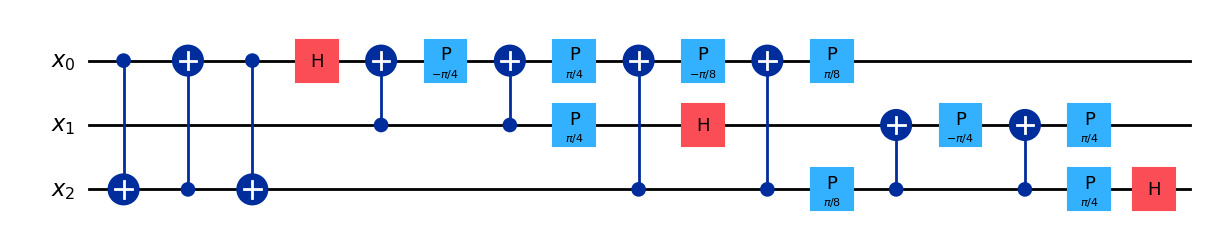

In [16]:
QFT(3).draw(output="mpl")

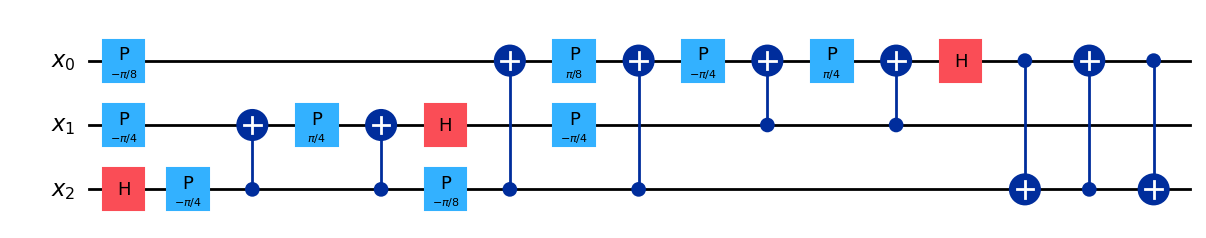

In [17]:
QFT_inverse(3).draw(output="mpl")

Now, the full calculator circuit (using the QFT).

In [18]:
def QFTCALC(d):
    # integer d for the length of input qubits
    
    # setting up the variables
    
    # first input number
    x = QuantumRegister(size=d, name="x") 
    
    # second input number
    y = QuantumRegister(size=d, name="y") 
    
    # operation determined by z; 0 for addition, 1 for multiplication
    z = QuantumRegister(size=1, name="z") 
    
    # "output" number; the circuit will send the zero state to the result (either x+y or x*y)
    w = QuantumRegister(size=d, name="w") 
    
    # ancillas used for calculation
    # this is only used for a c3x gate; in principal this could be avoided by decomposing c3x into cx and Toffoli gates.
    a = AncillaRegister(size=1, name="a")
    
       
    # Initiate the set-up of the circuit    
    QFT_calc = QuantumCircuit(x, y, z, w, a, name="QFTCALC")
    
    # Apply the QFT to w
    QFT_calc.compose(QFT(d),w,inplace=True)
    
    # flip z
    QFT_calc.x(z)
    
    # apply a QFT addition controlled by z
    # i.e. apply phase shifts to w based on the values of x and y
    
    for i in range(d):
        for j in range(d-i): 
            # angle of rotation
            theta = np.pi * 2**(i+j-d+1)
            
            # ccp(theta, z, x[j], w[i])
            QFT_calc.ccx(z,x[j],w[i])
            QFT_calc.p(-theta/2,w[i])
            QFT_calc.ccx(z,x[j],w[i])
            QFT_calc.p(theta/2,w[i])
            
            QFT_calc.cx(z,x[j])
            QFT_calc.p(-theta/4,x[j])
            QFT_calc.cx(z,x[j])
            QFT_calc.p(theta/4,x[j])
            QFT_calc.p(theta/4,z)
            
            # ccp(theta,z, y[j], w[i])
            
            QFT_calc.ccx(z,y[j],w[i])
            QFT_calc.p(-theta/2,w[i])
            QFT_calc.ccx(z,y[j],w[i])
            QFT_calc.p(theta/2,w[i])
            
            QFT_calc.cx(z,y[j])
            QFT_calc.p(-theta/4,y[j])
            QFT_calc.cx(z,y[j])
            QFT_calc.p(theta/4,y[j])
            QFT_calc.p(theta/4,z)
    
    # flip z back
    QFT_calc.x(z)
    
    # apply a QFT multiplication controlled by z
    # essentially, doing a QFT addition/phase shifts "qubit-wise" 
    
    for i in range(d):
        for j in range(d-i):
            theta = np.pi * 2**(i+j-d+1)
            
            #implement controlled phase shift with controls z,x[i],y[j], angle theta, target w[i+j]
            
            # cccx(z,x[i],y[j],w[i+j])            
            QFT_calc.ccx(x[i],y[j],a)
            QFT_calc.ccx(z,a,w[i+j])
            QFT_calc.ccx(x[i],y[j],a)
            
            # cp(-theta/2,z,w[i+j])            
            QFT_calc.cx(z,w[i+j])
            QFT_calc.p(theta/4,w[i+j])
            QFT_calc.cx(z,w[i+j])
            QFT_calc.p(-theta/4,w[i+j])
            QFT_calc.p(-theta/4,z)
            
            # cccx(z,x[i],y[j],w[i+j])
            QFT_calc.ccx(x[i],y[j],a)
            QFT_calc.ccx(z,a,w[i+j])
            QFT_calc.ccx(x[i],y[j],a)
            
            # cp(theta/2,z,w[i+j])
            QFT_calc.cx(z,w[i+j])
            QFT_calc.p(-theta/4,w[i+j])
            QFT_calc.cx(z,w[i+j])
            QFT_calc.p(theta/4,w[i+j])
            QFT_calc.p(theta/4,z)
            
            QFT_calc.ccx(z,x[i],y[j])
            
            # cp(-theta/4,z,y[j])            
            QFT_calc.cx(z,y[j])
            QFT_calc.p(theta/8,y[j])
            QFT_calc.cx(z,y[j])
            QFT_calc.p(-theta/8,y[j])
            QFT_calc.p(-theta/8,z)
            
            QFT_calc.ccx(z,x[i],y[j])
            
            # cp(theta/4,z,y[j])            
            QFT_calc.cx(z,y[j])
            QFT_calc.p(-theta/8,y[j])
            QFT_calc.cx(z,y[j])
            QFT_calc.p(theta/8,y[j])
            QFT_calc.p(theta/8,z)
            
            # cp(theta/4,z,x[i])            
            QFT_calc.cx(z,x[i])
            QFT_calc.p(-theta/8,x[i])
            QFT_calc.cx(z,x[i])
            QFT_calc.p(theta/8,x[i])
            QFT_calc.p(theta/8,z)
    
    
    
    # finish by applying the inverse of QFT
    QFT_calc.compose(QFT_inverse(d),w,inplace=True)
            
    return QFT_calc

This circuit ends up being more complex (in this fundamental implementation). Note that directly applying (multi-)controlled phase shifts rather than decomposing into CX, Toffoli and P gates would simplify this circuit greatly (and probably a more efficient decomposition into elementary gates is possible than those used above). In any case, the number of gates is still $O(d^{2})$. Below is the circuit for $d=1$:

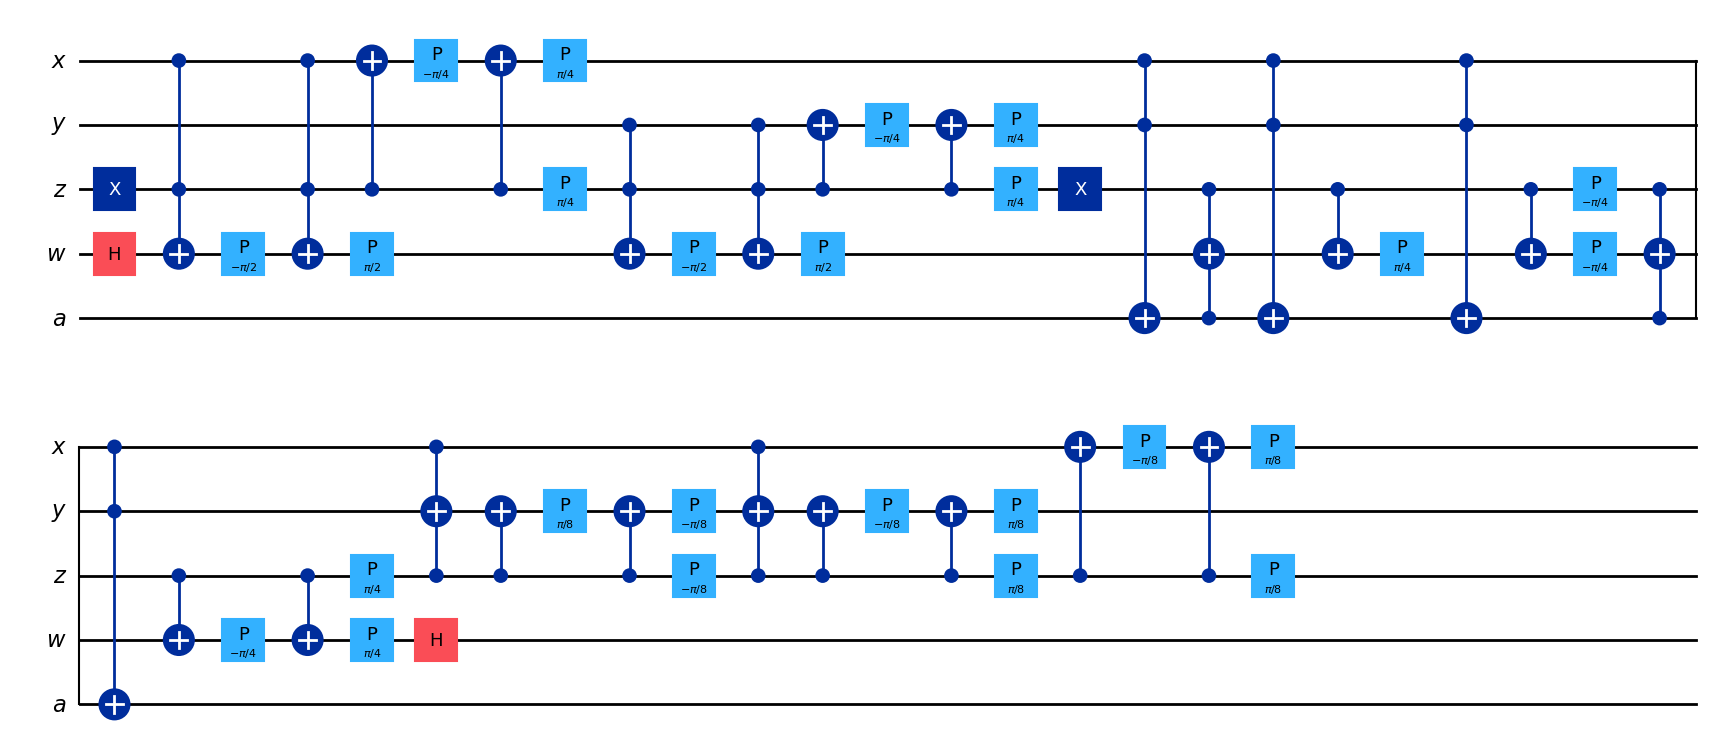

In [19]:
QFTCALC(1).draw(output="mpl")

**Example 2** We give the same examples as before but now with the QFTCALC circuit. First, $1+0=1$:

In [33]:
QFTCALC_matrix = Operator(QFTCALC(1))

In [34]:
start_vector_two_a = np.zeros(2**5)
start_vector_two_a[1] = 1 # position 1 corresponds to the basis vector with x in state 1 and the other qubits in state 0
start_vector_two_a.reshape(-1,1)



end_vector_two_a = np.matmul(QFTCALC_matrix, start_vector_two_a)
print(end_vector_two_a)

[0.+0.00000000e+00j 0.+5.88784672e-17j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 1.+1.96261557e-17j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j]


Note that (modulo a small amount of noise) the position of the 1 at index 9 in the result again corresponds to $x$ and $w$ in state 1. Next, $1\times 1=1$:

In [35]:
start_vector_two_b = np.zeros(2**5)
start_vector_two_b[7] = 1 # position 7 corresponds to the basis vector with x, y and z in state 1 and the other qubits in state 0
start_vector_two_b.reshape(-1,1)

end_vector_two_b = np.matmul(QFTCALC_matrix, start_vector_two_b)
print(end_vector_two_b)

[0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 1.+1.57009246e-16j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j]


Again, the single entry 1 at index 15 corresponds to $x$, $y$, $z$ and now $w$ all in state $1$.